# Projeto 1 - Ciência dos Dados

Nome: João Gabriel Valentim Rocha

Nome: Enzo Dadier Lacks Zamberlan

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

In [45]:
#!pip install seaborn
#!pip install emoji
#!pip install pysinonimos
#!pip install nltk
#!pip install sklearn
#!pip install unidecode

___
Carregando algumas bibliotecas:

In [46]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import seaborn as sn
from nltk import SnowballStemmer

In [47]:
import re
import string
import emoji
import nltk
import pysinonimos.sinonimos as sinom
from emoji import UNICODE_EMOJI
import unidecode

In [48]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\gabri\Desktop\Matérias 2 semestre\cdados\P1\Classificador_automatico_de_sentimentos


Carregando a base de dados com os tweets classificados como relevantes e não relevantes:

In [49]:
filename = 'assets/l.xlsx'

In [50]:
train = pd.read_excel(filename)
train

,Treinamento,Relevancia
0,mood de hj: bolsominion veio falar com loki:\n...,0
1,sdds do loki,1
2,"considerações finais de loki: parabéns marvel,...",1
3,@_namizinhaa @yaluv_ @_girlrainbow versão femi...,0
4,o loki merece todo o amor do mundo ? \n \n si...,1
...,...,...
595,"eu amo a sylvie e shippo sylki, mas meu sonho ...",1
596,pessoa desculpas pela pessoa que eu serei quan...,1
597,@douctorrfate loki como se ninguém fosse perce...,0
598,glr tô vendo loki hj pela primeira vez e tô go...,1


In [51]:
test = pd.read_excel(filename, sheet_name = 'Teste')
test

,Teste,Relevancia
0,comecei loki e logo no primeiro episódio ele s...,1
1,@thylaspirk exatamente \nnão dá cara loki mere...,1
2,pq a marvel falou que loki é irmão se thor sen...,0
3,vou fazer com o loki 🥰🤣 https://t.co/qry6pytktj,0
4,@stawocon loki eu ainda vi dnv ksksksksksksksk...,1
...,...,...
195,"vou fazer uma xícara temática pra mim, mas tô ...",0
196,o primeiro dente de leite de loki caiu https:/...,0
197,@mobiusdaavt @loki_l4ufeys0n eu vou te bloquear,0
198,queria ter juntado uma semana de merda de loki...,0


___
## Classificador automático de sentimento


Faça aqui uma descrição do seu produto e o que considerou como relevante ou não relevante na classificação dos tweets.

O classificador automático de sentimentos montado tem como critério utilizado a relevância de tweets que remetam a alguma reação ou laço sentimental em relação à série, sendo os mesmos positivos ou não (elogiando algum episódio, comentando valores da série, ou ainda, criticando os mesmos). Neste sentido, postagens que dizem respeito unicamente a aspectos nesse tocante, elogiando ou comentando sobre os atores da obra, como também tweets com vagas menções sobre a série, foram considerados como irrelevantes.

### Procedimentos e configurações iniciais

Para continuarmos, é necessário definir algumas funções básicas que vão nos ajudar:

1) Primeiro, vamos fazer a limpeza dos tweets. Retirando simbolos e pontuações que não serão contabilizadas para nossa análise

2)

In [52]:
# Passo 0
def separa_emoji(tweet):
    # Essa função separa os emojis e transcreve suas respectivas descrições
    modified=' '.join(emoji.get_emoji_regexp().split(tweet))
    modified=modified.split()
    for i,emoji1 in enumerate(modified):
        if emoji1 in UNICODE_EMOJI['pt']:
            modified[i]=UNICODE_EMOJI['pt'][emoji1].replace(':','')
        elif emoji1 in UNICODE_EMOJI['en']:
            modified[i]=UNICODE_EMOJI['en'][emoji1].replace(':','')
        else:
            continue
    modified=' '.join(modified)
        
    return modified

In [53]:
# Passo 1
stemmer = SnowballStemmer('portuguese')
def limpa_frase(frase):
    # Primeiro, poe todas as palavras com letras minúsculas
    aux = frase.lower()
    
    # Segundo, remove # and @
    aux = re.sub("@[A-Za-z0-9_]+","", aux)
    aux = re.sub("#[A-Za-z0-9_]+","", aux)
    
    # Terceiro, remove links
    aux = re.sub(r"http\S+", "", aux)
    aux = re.sub(r"www.\S+", "", aux)
    
    # Quarto, remove pontuação
    aux = re.sub('[()!?]', ' ', aux)
    aux = re.sub('\[.*?\]',' ', aux)
    
    # Quinto, separa e troca os emojis pela sua respectiva descrição
    aux = separa_emoji(aux)
    aux = aux.replace("_", "")
    
    # Sexto, remove acentos
    aux = unidecode.unidecode(aux)
    
    # Sétimo, remove não alfa-numericos
    aux = re.sub("[^a-z0-9]"," ", aux)
    
    # Oitavo, aplica Stemming
    aux_2 = ''
    lista_das_palavras = aux.split()
    for palavra in lista_das_palavras:
        nova_palavra = stemmer.stem(palavra)
        aux_2 += nova_palavra + ' '
    aux = aux_2.rstrip()
    
    return aux

In [54]:
# Passo 2
# transforma uma string em uma lista, de tal forma que é possível acessar palavra por palavra
def tokenize(frase):
    return frase.split()

In [55]:
# Passo 3
# Aqui serão contabilizadas as "stop words"
nltk.download('stopwords')
prep = nltk.corpus.stopwords.words('portuguese')
prep.append('')
prep = prep + ['n', 's', 'pq', 'q', 'to', 'pra', 'ja']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
# Passo 4
# Essa função retira as stop words de uma lista tokenizada
def no_stop_words(token):
    clear = []
    for element in token:
        if element not in prep:
            clear.append(element)
    return clear

In [57]:
# Passo 5
# Essa função aplica o stemming, pegando a raiz das palavras
def to_stemmer(aux):
    aux_2 = ''
    lista_das_palavras = aux.split()
    for palavra in lista_das_palavras:
        nova_palavra = stemmer.stem(palavra)
        aux_2 += nova_palavra + ' '
    aux = aux_2.rstrip()
    return aux

In [58]:
# Auxiliar para transformar de lista para string
def list_to_string(lista):
    return ' '.join(lista)

In [59]:
# Função final que limpa todo tweet e devolve em formato de string
def limpa_tweet(tweet):
    return list_to_string(no_stop_words(tokenize(limpa_frase(tweet))))

In [60]:
# Gera uma pd.Series do set_frases
def frases_to_series(set_frases):
    set_frases += ' '
    return pd.Series(tokenize(set_frases.sum()))

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

In [61]:
# Transformando palavras em variáveis categóricas
train['Treinamento'] = train['Treinamento'].astype('category')
test['Teste'] = test['Teste'].astype('category')

In [62]:
# Aplicando funções de limpeza e certificação no dataframe de treinamento da base de dados
train['Clean'] = train['Treinamento'].apply(limpa_tweet)
test['Clean'] = test['Teste'].apply(limpa_tweet)

In [63]:
# Separa os tweets relevantes dos irrelevantes
train_rel = train[train['Relevancia'] == 1]
train_irrel= train[train['Relevancia'] == 0]

In [64]:
# Gera uma pd.Series das palavras relevantes e irrelevantes do training set
palavras_rel = frases_to_series(train_rel['Clean'])
palavras_irrel = frases_to_series(train_irrel['Clean'])

In [65]:
# Gera duas listas com as palavras relevantes e irrelevantes e gera uma lista total
lista_palavras_rel = list(palavras_rel)
lista_palavras_irrel = list(palavras_irrel)
lista_palavras = lista_palavras_rel + lista_palavras_irrel
lista_palavras_sem_repeticao = list(set(lista_palavras))

In [66]:
# Gera um pd.Series da lista com todas as palavras
palavras = pd.Series(lista_palavras)

In [67]:
# Frequencias relativas
freq_palavras_relevantes = palavras_rel.value_counts(True)
freq_palavras_irrelevantes = palavras_irrel.value_counts(True)
freq_palavras_total = palavras.value_counts(True)

# Frequencias absolutas
freq_palavras_relevantes_abs = palavras_rel.value_counts()
freq_palavras_irrelevantes_abs = palavras_irrel.value_counts()
freq_palavras_total_abs = palavras.value_counts()

In [68]:
#print(list(freq_palavras_relevantes.keys()))

## Probabilidades 

Aqui abordaremos os valores das probabilidades que serão imprescindíveis para a construção do modelo. Em primeiro lugar, note que as probabilidade de serem relevantes ou serem irrelevantes podem ser expressas da seguinte forma:
 
 * $P(R) \rightarrow $  Probabilidade de ser relevante
 * $P(I)=P(R^c) \rightarrow $  Probabilidade de ser irrelevante
 
Além disso, por serem complementares, temos que: $P(R) + P(I) = P(R) + P(R^c) = 1$
 

In [69]:
# Utilizando a razão entre a quantidade de palavras da lista de relevantes pelo número total, temos P_R
P_R = len(lista_palavras_rel) / len(lista_palavras)

# Por complementar, temos P_Rc
P_Rc = 1 - P_R

## Probabilidades Condicionais e o Teorema de Bayes
Temos que, para o cálculo de probabilidades condicionais, fazemos uso da seguinte relação:

$$P(A|B) = \frac{P(A \cap B)}{P(B)}$$

Onde, 
* $P(A|B) \rightarrow $ Probabilidade de A ocorrer, dado que B ocorreu  
* $P(A \cap B) \rightarrow $ Probabilidade de A ocorrer e B ocorrer
* $P(B) \rightarrow $ Probabilidade de B ocorrer

Analogamente, temos que:
$$P(B|A) = \frac{P(B \cap A)}{P(A)}$$

Onde, 
* $P(B|A) \rightarrow $ Probabilidade de A ocorrer, dado que B ocorreu  
* $P(B \cap A) \rightarrow $ Probabilidade de B ocorrer e A ocorrer
* $P(A) \rightarrow $ Probabilidade de B ocorrer

Note que as probabilidades da interseção podem comutar os eventos A e B, portanto: $P(B \cap A) = P(A \cap B)$

Dessa forma, podemos extrair o conhecido Teorema de Bayes:

$$P(A|B) = P(B|A).\frac{P(A)}{P(B)}$$



## O Classificador de Naive Bayes

O Classificador de Naive Bayes se baseia na construção de um modelo bag-of-word. Na análise de sentimento, queremos responder a seguinte pergunta: "Qual a probabilidade dessa frase ser relevante, dado esse conjunto de palavras?". Nesse sentido, é necessário computar esse cálculo utilizando probabilidades condicionais e o resultado do teorema de Bayes encontrado na sessão anterior:

$$P(R|frase) = \frac{P(frase|R).P(R)}{P(frase)}$$

Dessa forma, nós vamos usar essa relação para encontrar $P(R|frase)$, ou seja, a probabilidade de uma frase ser relevante, dado o conjunto de palavras. Para tanto, tome como exemplo a frase: "meu avô ama isso", em termos de notação, queremos encontrar:

$$P(R|frase) = \frac{P(frase|R).P(R)}{P(frase)}$$

Para prosseguir, utilizaremos um processo de "Tokenização", que consiste em dividir a frase em pedaços menores (as palavras) e assumir que uma palavra não influencia na colocação da outra. Sabemos que isso não é verdade, mas utilizaremos por questões de simplificação (essa é a ingenuidade do classificador de Naive Bayes). Portanto, nosso cálculo ficara da seguinte forma:

$$P(frase|R) = P("meu"|R).P("avô"|R).P("ama"|R).P("isso"|R)$$

Logo, nossa expressão final será:

$$P(R|frase) = \frac{P("meu"|R).P("avô"|R).P("ama"|R).P("isso"|R).P(R)}{P(frase)}$$

Analogamente, para encontrarmos a probabilidade dele ser irrelevante, podemos fazer o mesmo cálculo:

$$P(I|frase) = \frac{P("meu"|I).P("avô"|I).P("ama"|I).P("isso"|I).P(I)}{P(frase)}$$

Agora, basta compararmos os valores das probabilidades:

Se, $P(R|frase) > P(I|frase)$, então, é mais provável que a frase seja $relevante$


Caso contrário, $P(R|frase) < P(I|frase)$, então, é mais provável que a frase seja $irrelevante$

### Suavização de Laplace

É importante ressaltar que para o caso de uma determina palavra em uma frase não pertencer ao nosso conjunto universo, a probabilidade atribuida a essa palavra será zero. Porém, não podemos utilizar a probabilidade de 0 por razões algébricas, portanto, utilizaremos a <b><em>Suavização de Laplace</em></b>. Basicamente essa ferramenta irá nos ajudar a inserir a palavra "estranha" no quesito probabilístico das categorias discutidas.

$$P(palavra|W) = \frac{F_{AW}+1}{P_{W}+P_{P}}$$

Onde: 

$ F_{AW} \rightarrow$ Frequência absoluta da palavra na categoria W
    
$P_{W} \rightarrow$ Todas as palavras pertencentes às frases rotuladas como da categoria W
    
$P_{P} \rightarrow$ Todas as palavras possíveis sem repetição

Nesse sentido, tome $W$ como sendo o evento $R$ e $W^c$ como sendo o evento $I$ ou $R^C$. Dessa forma, a soma do valor 1 faz com que o nosso resultado de $P(R|frase)$ ou $P(I|frase)$ nunca se torne zero, mesmo que a frequência absoluta da palavra seja zero.


In [70]:
'''
A suavização de Laplace será utilizada para os casos em que uma determinada palavra da frase não se encontra 
no conjunto universo.
'''
def smoothing(palavra, relevancia, freq_palavras_abs, alfa=1):
    '''
    alfa -> Parâmetro de suavização
    alfa = 1 (Suavização de Laplace)
    alfa < 1 (Suavização de Lidstone)
    '''
    try:
        FAW = freq_palavras_abs[palavra]
    except:
        FAW = 0
    if relevancia == 'R':
        return (FAW + alfa) / (len(lista_palavras_rel) + alfa * len(lista_palavras_sem_repeticao))
    return (FAW + alfa) / (len(lista_palavras_irrel) + alfa * len(lista_palavras_sem_repeticao))

In [71]:
# Função que calcula a probabilidade que queremos para fazer a desigualdade e decidir a categoria mais provável
def P(relevancia, frase):
    if type(frase) != list:
        frase = tokenize(frase)
    if relevancia == 'R':
        P_F_dado_R = 1
        for palavra in frase:
            P_F_dado_R *= smoothing(palavra, relevancia, freq_palavras_relevantes_abs)
        P_R_dado_F = P_F_dado_R * P_R
        return P_R_dado_F
            
    elif relevancia == 'I' or relevancia == 'Rc':
        P_F_dado_Rc = 1
        for palavra in frase:
            P_F_dado_Rc *= smoothing(palavra, relevancia, freq_palavras_irrelevantes_abs)
        P_Rc_dado_F = P_F_dado_Rc * P_Rc
        return P_Rc_dado_F
    return None

In [72]:
# Função final que recorre ao modelo de Naive Bayes
def NaiveBayesModel(frase):
    if P('R', frase) > P('I', frase):
        return 1
    return 0

In [73]:
# Função final que recorre ao modelo de Naive Bayes
def NaiveBayesModel_MonteCarlo(frase):
    p1 = P('R', frase)
    p2 = P('I', frase)
    if p1 > 0.6 or p2 > 0.6:
        if p1 > p2:
            return 1
        return 0
    else:
        p1_plus_p2 = p1 + p2
        lambda_1 = p1 / p1_plus_p2
        lambda_2 = p2 / p1_plus_p2
        z = random.random()
        if z < lambda_1:
            return 1
        return 0

___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [74]:
test['Modelo'] = test['Clean'].apply(NaiveBayesModel)

In [75]:
verdadeiros_positivos = test.loc[(test['Modelo'] == 1) & (test['Relevancia'] == 1),:].shape[0]
falsos_positivos = test.loc[(test['Modelo'] == 1) & (test['Relevancia'] == 0),:].shape[0]
print(f'O percentual de verdadeiros positivos foi de: {100*(verdadeiros_positivos)/test.shape[0]:.2f}%')
print(f'O percentual de falsos positivos foi de: {100*(falsos_positivos)/test.shape[0]:.2f}%')

O percentual de verdadeiros positivos foi de: 23.00%
O percentual de falsos positivos foi de: 40.50%


In [76]:
verdadeiros_negativos = test.loc[(test['Modelo'] == 0) & (test['Relevancia'] == 0),:].shape[0]
falsos_negativos = test.loc[(test['Modelo'] == 0) & (test['Relevancia'] == 1),:].shape[0]
print(f'O percentual de verdadeiros negativo foi de: {100*(verdadeiros_negativos)/test.shape[0]:.2f}%')
print(f'O percentual de falsos negativo foi de: {100*(falsos_negativos)/test.shape[0]:.2f}%')

O percentual de verdadeiros negativo foi de: 32.50%
O percentual de falsos negativo foi de: 4.00%


In [77]:
print(f'A acurácia do modelo foi de: {100*(verdadeiros_negativos+verdadeiros_positivos)/test.shape[0]:.2f}%')

A acurácia do modelo foi de: 55.50%


In [78]:
# Função importante para o último item desse projeto
def calcula_metricas(testing):
    verdadeiros_positivos = testing.loc[(testing['Modelo'] == 1) & (testing['Relevancia'] == 1),:].shape[0]
    falsos_positivos = testing.loc[(testing['Modelo'] == 1) & (testing['Relevancia'] == 0),:].shape[0]
    verdadeiros_negativos = testing.loc[(testing['Modelo'] == 0) & (testing['Relevancia'] == 0),:].shape[0]
    falsos_negativos = testing.loc[(testing['Modelo'] == 0) & (testing['Relevancia'] == 1),:].shape[0]
    acuracia = (verdadeiros_negativos+verdadeiros_positivos)
    return (verdadeiros_positivos * 100)/test.shape[0], (falsos_positivos * 100)/test.shape[0], (verdadeiros_negativos * 100)/test.shape[0], (falsos_negativos * 100)/test.shape[0], (acuracia * 100)/test.shape[0]

#### Mapa de Calor
Para visualizar melhor os percentuais, vamos utilizar a biblioteca Seaborn para plotar um mapa de calor, a partir de uma tabela cruzada que será criada na célula seguinte.

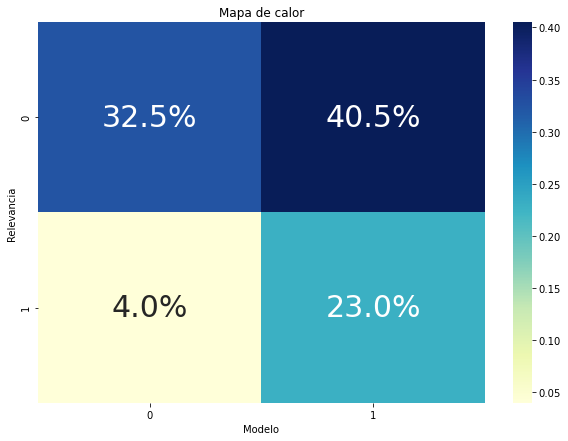

In [79]:
tabela_cruzada = pd.crosstab(test.Relevancia, test.Modelo, normalize=True)
plt.figure(figsize=(10,7))
plt.title('Mapa de calor')
sn.heatmap(tabela_cruzada, annot=True, annot_kws={"size": 30}, fmt='.1%', cmap='YlGnBu')
plt.show()

___
### Concluindo

   No classificador automático criado, que tem por objetivo adotar critérios acerca dos sentimentos sobre a série, como visto  no mapa de calor e seus dados de precisão, há uma acurácia de 53.50%, com um percentual de verdadeiros negativo de 37.50% e um percentual de falsos negativo de 18.00%.
   
   Dentro deste universo, é essencial acrescentar que os grandes responsáveis por esses erros são os falsos positivos, já que trazem uma caracterização errônea ao classificador em questão. Desta forma, também é importante destacar que ao promover o uso de um data base pequeno, o algorítmo criado apresenta uma classificação mais arbritrária, enquanto que se a mesma for feita por mais informações e informações mais abrangentes, apresentará resultados mais satisfatórios e precisos, dentro de uma 'subjetividade' criada por probabilidades e espaços amostrais que envolvem os dados em questão. Com isso, sendo possível receber um output biinário resposável por definir os mesmos em relevantes, ou ainda, irrelevantes. Ou seja, classificar automaticamente os dados em questão.
  
   Contudo, pode-se definir, por fim, um funcionamento adequado ao próprio classificador, mas não ideal, sendo que uma vez que "naive" (ou seja, ingênuo) desconsidera a relação entre as palavras, abrindo brechas para classificações incorretas acerca dos procedimentos de sarcasmo, dupla negação, ironia, ambiguidade e figuras de linguagem - sendo sarcasmo e dupla negação discutidos abaixo. Fato que mesmo o aumento dos dados coletados por ele podem não sanar, tendo em mente apenas a eficácia da análise matemática e não de granática, sentido ou sintaxe aplicadas aos tweets.
   
   Através disso, tendo em vista o funcionamento adequado do produto em questão (dentro de aspectos matemáticos), essa funcionalidade poderia de fato ser expandida para outros universos, como a comparação de avaliações positivas e negativas acerca de um determinado produto, ou ainda, coletando a relevância de feedbacks apresentados pelos usuários de determidao produto-serviço, a fim de potencializar a sua eficácia e produtividade. Deste modo, sendo intrínseco ao projeto a necessidade contínua de alimentação financeira, para que o classificador criado possa continuar em andamento, se desenvolvendo e abrangindo maiores ramos no mundo de coleta e classificação de dados, tanto para pesquisa de satisfação quanto para melhoria dos ideias de certa empresa.

#### Por que não posso utilizar minha base de Treinamento para checar a acurácia do meu classificador?

Sobretudo, num contexto de um pequeno data set, ocorrerá um efeito chamado <b>Overfitting</b>, que ocorre devido ao fato de o conjunto de treinamento não ser suficientemente grande para gerar classificações mais acertivas quando o sistema recebe novas instâncias (novos tweets). 

Esse efeito pode ser simbolizado pelo gráfico a seguir:

<img src="assets/overfitting_2.png" width=400 >
<center><b>Figura 1 - Visualização do overfitting para data sets pequenos</b></center>

####  Por que não posso alimentar minha base de Treinamento automaticamente usando o próprio classificador?

Como vimos anteriormente, existe uma simplificação que fizemos na implementação do modelo que pode prejudicar o julgamento do algoritmo ao receber uma nova instância (novo tweet). Em tópicos anteriores vimos que as considerações foram estritamente algébricas, não levando em conta o valor semântico, gramático e a influência de uma palavra às demais da frase.

Nesse sentido, ao utilizarmos o próprio classificador para alimentar a base de treinamento, estaríamos propagando um viés cada vez maior, prejudicando o treinamento do nosso modelo. Dessa forma, é preciso que os tweets sejam rotulados manualmente e com um critério estático, mesmo que isso apresente um certo grau de subjetividade. É importante mencionar que esse tipo de sistema de aprendizado é Supervisionado, portanto, é necessário que nosso conjunto de treinamento esteja rotulado de forma adequada para que obtenhamos o máximo de êxito ao classificar uma nova instância.



#### Sarcasmo e dupla negação

<b>1) Sarcasmo</b>

Este tópico é pautado em uma consideração que fizemos para a construção do modelo. Como vimos, por questões de simplificação, o classificador de Naive Bayes considera a independência entre as palavras (<b>a ingenuidade de Naive Bayes</b>). Apesar de ser uma consideração razoável, é possível prever que o classificador não funciona muito bem diante de um tweet sarcástico, por exemplo. 

Diante disso, acompanhe um caso que pode ser um bom exemplo disso:

In [80]:
frase_1 = 'eu amo loki tanto quanto tomar uma paulada'
if NaiveBayesModel(frase_1) == 1:
    print('A frase 1 é RELEVANTE')
else:
    print('A frase 1 é IRRELEVANTE')

A frase 1 é RELEVANTE


<b>2) Dupla Negação</b>

Analogamente ao caso anterior, é possível estender essa análise para frases com dupla negação. 

Diante disso, acompanhe um caso que pode ser um bom exemplo disso:


In [81]:
frase_2 = 'loki não é nada agradável'
if NaiveBayesModel(frase_2) == 1:
    print('A frase 2 é RELEVANTE')
else:
    print('A frase 2 é IRRELEVANTE')

A frase 2 é RELEVANTE


Com os exemplos acima é possível inferir, portanto, que tweets de caráter sarcástico ou com dupla negação muito provavelmente serão classificados de maneira errônea. Isso se deve, sobretudo, à <b>ingenuidade do classificador de Naive Bayes</b>. 

### Novos cenários para o classificador de Naive Bayes

<b>1)</b> A aplicação do modelo ingênuo de Bayes para prever a doença de Alzheimer a partir de dados de todo o genoma (Wei Wei, et al. 2011)

Nesse artigo, é utilizado o modelo de Naive Bayes para identificar e prever a doença de Alzheimer. O ponto princípio da implementação se encontro no tópico "<b>The naive Bayes model</b>", onde ele mostra a consideração que aqui discutimos:

<img src="assets/ox_article.png" width=400 >
<center><b>Figura 1 - Consideração da Ingenuidade do modelo</b></center>

Nesse caso, as features são os componentes pertencentes ao genoma (fazendo o paralelo, seriam a substituição das palavras dos nossos tweets). Dessa forma, é possível ver uma primeira grande aplicação para o modelo de Naive Bayes, que ainda não havia sido discutida.

* Fonte: https://academic.oup.com/jamia/article/18/4/370/732731?login=true

<b>2)</b> Uma nova aplicação do classificador Naive Bayes na previsão de energia fotovoltaica (Ramazan Bayindir, et al. 2017)

Nesse artigo, é utilizado o modelo de Naive Bayes para identificar e prever a quantidade de energia gerada por paineis fotovoltaicos. Os pesquisadores utilizaram um conjunto de dados coletados por 1 ano, que registram valores de varias features como temperatura e duração total do sol. 

As aplicações do modelo de Naive Bayes nesse artigo podem ser de fundamental importância no mundo contemporânea, haja vista a necessidade de cada vez mais aplicações de energias limpas (como a energia solar) e para tanto, é necessário um aparato tecnológico consistente para tal atividade.

* Fonte: https://ieeexplore.ieee.org/abstract/document/8260684

<b>3)</b> Filtro de spam utilizando o modelo de Naive Bayes (DILIP KUMAR, et al. 2018)

Nesse artigo do famoso site Kaggle, é possível ver uma aplicação muito interessante (e presente no nosso cotidiano) de um filtro de Spam utilizando o modelo de Naive Bayes. Com um grande número de e-mails já rotulados, será possível criar o modelo exatamente como fizemos nesta aplicação. Portanto, temos uma mudança significativa de ambiente, porém utilizaremos o mesmo sistema de aprendizado para tal.


* Fonte: https://www.kaggle.com/dilip990/spam-ham-detection-using-naive-bayes-classifier

### Sugestões de melhorias para o Classificador

##### 1) Stemming and Lemmatization

   O stemming de palavras pode ser um caminho muito pertinente para a melhoria da acurácia. A técnica consiste em transformar as palavras da frase em sua raiz (que pode acabar resultando em palavras que não existe). Em contrapartida, o Lemmatization obtém sua forma canonica e gramaticalmente correta. Ambas as técnicas despendem um grande custo computacional e impactam a performance da classificação, porém podem ser uma solução para elevar o percentual de acurácia.
   
   Nesse sentido, é possível utilizar a biblioteca de linguagem natural <b>(nltk - Natural Language Toolkit)</b>, caso você não tenha essa biblioteca instalada utilize o comando:

>**!pip install nltk**

   * Para mais informações, acesse o site oficial: https://www.nltk.org/
   
   * Outro link que pode ajudar: [Artigo Datacamp tutorial](https://www.datacamp.com/community/tutorials/stemming-lemmatization-python?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=278443377095&utm_targetid=aud-392016246653:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=1001773&gclid=Cj0KCQjwv5uKBhD6ARIsAGv9a-xGXnN7nhmmTGQ-Fdgb38Qz92hH3S3LnFQOyoOz1Mta4OCa4enwGg8aAseSEALw_wcB)

##### 2) Formação de N-gramas de palavras

   A formação de N-gramas pode contrabalancear o problema da Ingenuidade do modelo. A consideração de que as palavras são independentes umas das outras, apesar de funcionar, prejudica o julgamento do sistema de aprendizado para novas instâncias. Logo, uma maneira de deixar o modelo mais sólido é construir N-gramas na formação das palavras.
   Segundo estudos (Vlado Keˇselj, et al 2003), é possível melhorar significativamente a acurácia de textos em inglês utilizando N-gramas com N entre 4 e 8. Portanto, um tópico que poderia ser abordado é a formação de N-gramas.
   
   Nesse sentido, é possível utilizar a biblioteca de linguagem natural <b>(nltk - Natural Language Toolkit)</b>, caso você não tenha essa biblioteca instalada utilize o comando:

>**!pip install nltk**

   Com a biblioteca instalada, utilize os comandos a seguir para gerar seus N-gramas (lembre-se da tokenização):

In [82]:
# import nltk
my_text = 'Estou interessado em aprender Machine Learning'
words = tokenize(my_text)
my_bigrams = nltk.bigrams(words)
my_trigrams = nltk.trigrams(words)
for word in my_bigrams:
    print(word)
for word in my_trigrams:
    print(word)

('Estou', 'interessado')
('interessado', 'em')
('em', 'aprender')
('aprender', 'Machine')
('Machine', 'Learning')
('Estou', 'interessado', 'em')
('interessado', 'em', 'aprender')
('em', 'aprender', 'Machine')
('aprender', 'Machine', 'Learning')


* Para mais informações, acesse o site oficial: https://www.nltk.org/

##### 3) Aumentar o tamanho da base de dados de treinamento

   Das várias propostas possíveis, essa é uma das mais intuitivas. Em tópicos anteriores, falamos a respeito dos efeitos negativos de se utilizar uma base de dados pequena, ao aumentarmos o nosso conjunto de amostras (lembre-se do bag of word model) daremos mais instâncias para o nosso sistema se basear e aprender a classificar instâncias não vistas antes. 

Dessa forma, uma saída possível é classificarmos cada vez mais tweets para alimentar mais nossa base de treinamente e conferir maior acurácia para nosso modelo.

##### 4) Utilização do método de Monte Carlo para variáveis aleatórias

   Como vimos até aqui, o modelo de Naive Bayes utiliza a comparação de duas probabilidades condicionais através do teorema de Bayes. Para decidir a relevância ou não, só verificamos qual probabilidade é maior e atribuimos a esta a classifição da nova instância. Porém, apesar de ser considerada a mais provável, ainda é possível que a menos provável seja a classificação real. Aqui entra o método de Monte Carlo. É possível gerar números aleatório no intervalo de 0 a 1, caso o número gerado seja menor que a probabilidade de ser relevante dado um tweet, essa instância será classificada como relevante, caso contrário, como irrelevante. Vale ressaltar que esse método provavelmente será mais eficaz quando a base de dados for suficientemente grande.

___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Caso for fazer esse item do Projeto

In [83]:
test_split = pd.read_excel(filename, sheet_name = 'Teste').rename(columns={'Teste':'Total'})

train_split = pd.read_excel(filename, sheet_name = 'Treinamento').rename(columns={'Treinamento':'Total'})

#Concatenando
full_data = pd.concat([train_split,test_split])

#Limpando os tweets
full_data['Clean']=full_data['Total'].apply(limpa_tweet)
full_data.head()

,Total,Relevancia,Clean
0,mood de hj: bolsominion veio falar com loki:\n...,0,mood hj bolsominion vei fal lok nao lok bolsom...
1,sdds do loki,1,sdds lok
2,"considerações finais de loki: parabéns marvel,...",1,consideraco fin lok parabens marvel chor igual...
3,@_namizinhaa @yaluv_ @_girlrainbow versão femi...,0,versa feminin lok multivers
4,o loki merece todo o amor do mundo ? \n \n si...,1,lok merec tod amor mund sim sim sim


In [84]:
from sklearn.model_selection import train_test_split

In [85]:
lista_hist=[]

for i in range(100):
    
    #training_data, testing_data = train_test_split(full_data, test_size=0.2, random_state=random.randint(1,500))
    
    X_train, X_test, y_train, y_test = train_test_split(full_data[['Clean','Relevancia']],full_data.Relevancia,
    test_size=0.3)
    
    train_rel_new = X_train[X_train['Relevancia']==1]
    train_irrel_new = X_train[X_train['Relevancia']==0]
    
    palavras_rel = frases_to_series(train_rel_new['Clean'])
    palavras_irrel = frases_to_series(train_irrel_new['Clean'])
    
    # Gera duas listas com as palavras relevantes e irrelevantes e gera uma lista total
    lista_palavras_rel = list(palavras_rel)
    lista_palavras_irrel = list(palavras_irrel)
    lista_palavras = lista_palavras_rel + lista_palavras_irrel
    lista_palavras_sem_repeticao = list(set(lista_palavras))
    total = pd.Series(lista_palavras)

    # Frequencias absolutas
    freq_palavras_relevantes_abs = palavras_rel.value_counts()
    freq_palavras_irrelevantes_abs = palavras_irrel.value_counts()
    freq_palavras_total_abs = palavras.value_counts()

    P_R = len(lista_palavras_rel) / len(total)

    # Por complementar, temos P_Rc
    P_Rc = len(lista_palavras_irrel) / len(total)
    
    assert P_R+P_Rc==1

    X_test['Modelo'] = X_test['Clean'].apply(NaiveBayesModel)

    verdadeiros_positivos = X_test.loc[(X_test['Modelo'] == 1) & (X_test['Relevancia'] == 1),:].shape[0]
    verdadeiros_negativos = X_test.loc[(X_test['Modelo'] == 0) & (X_test['Relevancia'] == 0),:].shape[0]
    acuracia = (verdadeiros_positivos + verdadeiros_negativos)/X_test.shape[0]
    lista_hist.append(acuracia * 100)

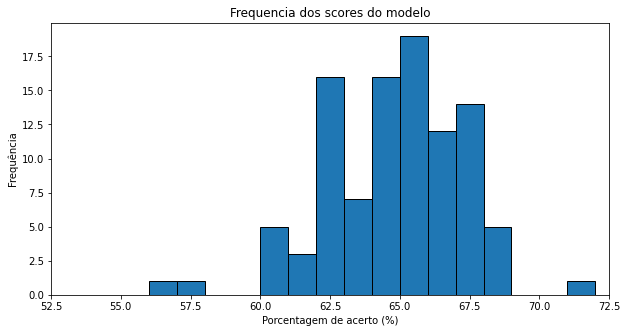

In [86]:
faixa=np.arange(30,99,1)
plt.figure(figsize=(10, 5))
plt.hist(lista_hist, bins=faixa, edgecolor='black', density=False)
plt.title('Frequencia dos scores do modelo')
plt.ylabel('Frequência')
plt.xlabel('Porcentagem de acerto (%)')
plt.xlim(52.5,72.5)
plt.show()

In [87]:
print('Score máximo: ', round(max(lista_hist), 2))
print('Score mínimo: ', round(min(lista_hist), 2))
print('Score médio: ', round(sum(lista_hist)/len(lista_hist), 2))

Score máximo:  71.25
Score mínimo:  56.25
Score médio:  64.75


Como podemos ver, a maneira como dispomos os conjuntos de teste e treino pode influenciar no score que o modelo pode alcançar. Tendo isso me vista, é imprescindível que estudos com diferentes disposições de conjuntos sejam feitas como no item anterior. Analisando o histograma, podemos observar que não seria produtivo utilizar uma única partição de conjunto de treinamento/teste, pelo falo de existir a possibilidade tanto de se obter scores elevados quanto de se obter scores mais baixos. Dessa forma, para a melhor construção do sistema de aprendizado, é imprescindível que se leve em consideração as partições de treinamento/teste que melhor se adequam aos objetivos do projeto.

In [88]:

frase = 'jogando jogar dançar'
#lista = ['play', 'playing', 'player']

___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* (x) IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nos tweets. Ex: stemming, lemmatization, stopwords 

* (x) CORRIGIU separação de espaços entre palavras e emojis ou entre emojis e emojis 

* (o) CRIOU categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante. Pelo menos quatro categorias, com adição de mais tweets na base, conforme enunciado. (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado) --------

* (x) EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento (x)

* (x) PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto (x)

* (o) SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa) 

* (o) FEZ o item 6. Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)

___
## Referências

* [Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**


* [A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**


* [The application of naive Bayes model averaging to predict Alzheimer's disease from genome-wide data](https://academic.oup.com/jamia/article/18/4/370/732731?login=true)


* [A Novel Application of Naive Bayes Classifier in Photovoltaic Energy Prediction](https://ieeexplore.ieee.org/abstract/document/8260684)


* [Spam/ham detection using Naive bayes Classifier](https://www.kaggle.com/dilip990/spam-ham-detection-using-naive-bayes-classifier)


* [Week 6 - Language - CS50 - Introduction to Artificial Inteligence with Python - HarvardX](https://cs50.harvard.edu/ai/2020/notes/6/)


* Vlado Keˇselj, Fuchun Peng, Nick Cercone, and Calvin Thomas. N-grambased author profiles for authorship attribution. In Proceedings of the conference pacific association for computational linguistics, PACLING, volume 3, pages 255–264, 2003